# Discover Ri

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../..")

In [3]:
import deepmatcher as dm
import pandas as pd
import torch

In [4]:
from utils.intermediate_layer_extraction import return_layer_input

In [5]:
walmartamazon_hybrid = dm.MatchingModel(attr_summarizer='hybrid')
walmartamazon_hybrid.load_state('../../models/walmartamazon_hybrid.pth')
walmartamazon_hybrid = walmartamazon_hybrid.cuda()

In [6]:
testneg  = return_layer_input(walmartamazon_hybrid,walmartamazon_hybrid.classifier,
    '../../datasets/Structured/Walmart-Amazon/','test_negatives')

In [7]:
testpos = return_layer_input(walmartamazon_hybrid,walmartamazon_hybrid.classifier,
                             '../../datasets/Structured/Walmart-Amazon/','test_positives')

In [8]:
negatives  = return_layer_input(walmartamazon_hybrid,walmartamazon_hybrid.classifier,
    '../../datasets/Structured/Walmart-Amazon/','negatives')

In [9]:
positives  = return_layer_input(walmartamazon_hybrid,walmartamazon_hybrid.classifier,
    '../../datasets/Structured/Walmart-Amazon/','positives')

## Ri discovery

### Negative samples analysis

In [8]:
from utils.ri_calculator import computeRi

In [11]:
attributes =['title','category','brand','modelno','price']
classifier_len = len(list(testpos.values())[0])
attribute_len = int(classifier_len/len(attributes))

In [11]:
neg_ri,neg_ri_norms = computeRi(walmartamazon_hybrid.classifier,attributes,testneg,0)


100%|██████████| 1856/1856 [04:55<00:00,  6.28it/s]


NameError: name 'torch' is not defined

In [14]:
torch.save(neg_ri,'experiment_results/testneg_ri_hybrid.pt')

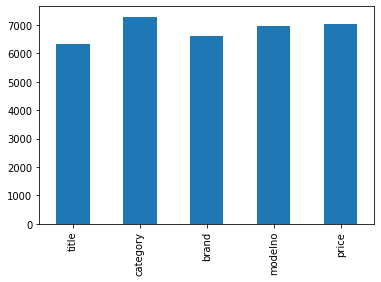

In [21]:
neg_ri_norms.sum(numeric_only=True).plot.bar()

In [12]:
def getRiNorms(ri,attributes):
    ri = ri.values()
    ri_norms = [[torch.norm(v).item() for v in ris] for ris in ri]
    ri_norms_df = pd.DataFrame(data=ri_norms,columns=attributes)
    return ri_norms_df

In [13]:
##save to file
neg_ri = torch.load('experiment_results/testneg_ri_hybrid.pt')
negatives_variation_df = getRiNorms(neg_ri,attributes)
negatives_variation_df.to_csv('experiment_results/testneg_ri_norms_hybrid.csv',index=False)

### Positive samples analysis

In [22]:
pos_ri, pos_ri_norms = computeRi(walmartamazon_hybrid.classifier,attributes,testpos,1)
torch.save(pos_ri,'experiment_results/testpos_ri_hybrid.pt')

100%|██████████| 193/193 [00:39<00:00,  4.91it/s]


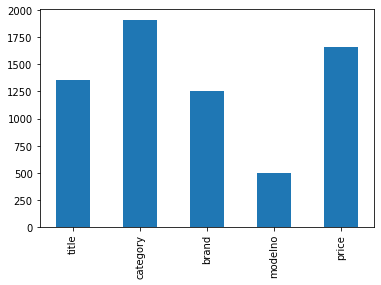

In [23]:
pos_ri_norms.sum(numeric_only=True).plot.bar()

In [22]:
positives_variation_df.to_csv('experiment_results/testpositives_ri_hybrid.csv',index=False)

In [14]:
##save to file
pos_ri = torch.load('experiment_results/testpos_ri_hybrid.pt')
pos_ri_norms = getRiNorms(pos_ri,attributes)
pos_ri_norms.to_csv('experiment_results/testpos_ri_norms_hybrid.csv',index=False)

## Nearest neighbors

In [24]:
from utils.distance_measures import calculate_nearest_neighbors_onAttributes

In [25]:
positives_nn = calculate_nearest_neighbors_onAttributes(testpos_classifier_inputs,testpos_ids,pos_ri,
                                                       neg_classifier_inputs,neg_ids,attributes,attribute_len
                                                       ,min_similarity=0.5)

100%|██████████| 65/65 [00:00<00:00, 77.98it/s]


In [26]:
negatives_nn = calculate_nearest_neighbors_onAttributes(testneg_classifier_inputs,testneg_ids,
                                                              neg_ri,pos_classifier_inputs,
                                                              pos_ids,attributes,attribute_len,
                                                       min_similarity=0.5)

100%|██████████| 128/128 [00:00<00:00, 543.71it/s]


In [27]:
positives_nn.to_csv('experiment_results/testpos_nn_hybrid_withfilter.csv',index=False)
negatives_nn.to_csv('experiment_results/testneg_nn_hybrid_withfilter.csv',index=False)

## Test

In [24]:
import torch.nn.functional as F

In [27]:
for key in testneg.keys():
    for idx,attr in enumerate(attributes):
        pred = F.softmax(walmartamazon_hybrid.classifier.forward(torch.unsqueeze(testneg[key]+neg_ri[key][idx],0)),dim=1)
        if pred[0][0].item() > pred[0][1].item():
            print(pred)

In [28]:
for key in testpos.keys():
    for idx,attr in enumerate(attributes):
        pred = F.softmax(walmartamazon_hybrid.classifier.forward(torch.unsqueeze(testpos[key]+pos_ri[key][idx],0)),dim=1)
        if pred[0][0].item()  pred[0][1].item():
            print(pred)